In [34]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, GlobalMaxPooling1D, Dropout
from tensorflow.keras.models import Model 
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [35]:
#importing data
X = np.load("training_data/sequences.npy")
y = np.load("training_data/labels.npy")

In [37]:
#try scaling for real time performance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15)
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)
print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (722, 30, 1662)
X_test:  (128, 30, 1662)


In [38]:
#logs
log_dir = os.path.join('logs')
tb_callback = TensorBoard(log_dir = log_dir)
# reduceLR_callback = ReduceLROnPlateau(monitor = 'val_loss', min_lr = 1e-5)

In [39]:
#Shuffling dataset between epochs
buffer_size = 1000
batch_size = len(X_train)//10  
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(batch_size)

In [40]:
#LSTM model:
i = Input(shape = X_train[0].shape)
#choose b/w ReLU and tanh activation
x = LSTM(64, return_sequences = True)(i) 
x = LSTM(64, return_sequences = True)(x)
x = GlobalMaxPooling1D()(x)
x = Dropout(0.3)(x)
x = Dense(64, activation = 'relu')(x)
x = Dense(len(list(set(y))), activation = 'softmax')(x)

LSTM_model = Model(i, x)

In [41]:
LSTM_model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)
r = LSTM_model.fit(
    train_dataset, 
    validation_data = test_dataset, 
    epochs = 1000,
    callbacks = [tb_callback]
    )

Epoch 1/1000
11/11 [==============================] - 6s 125ms/step - loss: 2.8308 - accuracy: 0.0582 - val_loss: 2.8304 - val_accuracy: 0.0859
Epoch 2/1000
11/11 [==============================] - 0s 36ms/step - loss: 2.8256 - accuracy: 0.1108 - val_loss: 2.8361 - val_accuracy: 0.0938
Epoch 3/1000
11/11 [==============================] - 0s 35ms/step - loss: 2.8179 - accuracy: 0.1039 - val_loss: 2.8073 - val_accuracy: 0.1250
Epoch 4/1000
11/11 [==============================] - 0s 34ms/step - loss: 2.7990 - accuracy: 0.1191 - val_loss: 2.7883 - val_accuracy: 0.1406
Epoch 5/1000
11/11 [==============================] - 0s 35ms/step - loss: 2.7915 - accuracy: 0.1094 - val_loss: 2.7669 - val_accuracy: 0.1406
Epoch 6/1000
11/11 [==============================] - 0s 34ms/step - loss: 2.7717 - accuracy: 0.1080 - val_loss: 2.7023 - val_accuracy: 0.1562
Epoch 7/1000
11/11 [==============================] - 0s 37ms/step - loss: 2.6969 - accuracy: 0.1233 - val_loss: 2.6291 - val_accuracy: 0.148

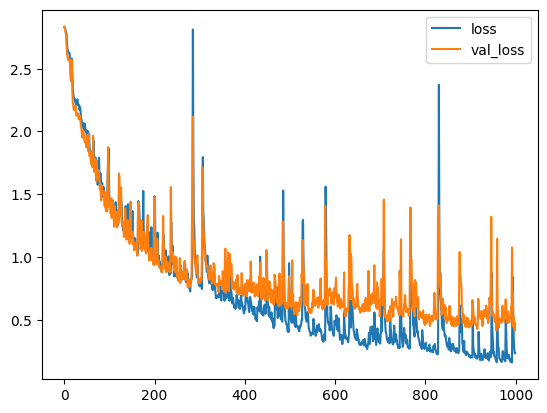

In [42]:
#loss:
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show() 

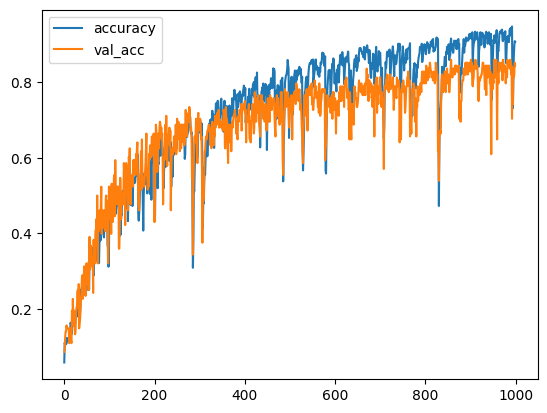

In [43]:
#accuracy:
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_acc')
plt.legend()
plt.show() 

In [45]:
LSTM_model.save('models/LSTM_model.h5')